In [ ]:
#!pip install tensorflow==2.1

%load_ext tensorboard
%tensorflow_version 2.x

!rm -r ./graphs/*


rm: cannot remove './graphs/*': No such file or directory


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re #regex

import nltk
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
from tensorflow.keras.models import load_model, Model,Sequential
from tensorflow.keras.layers import Dense,Reshape, Activation, Dropout, Input, LSTM, Dense,Embedding,Flatten, Bidirectional
from tensorflow.keras.initializers import glorot_uniform,Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LambdaCallback
from google.colab import files
import torch
import random
import sys
import io
from tensorflow.keras.preprocessing.sequence import pad_sequences 
import os
import multiprocessing
from gensim.models import Word2Vec
import string

from tensorflow.keras.utils import to_categorical

from google.colab import drive
drive.mount('/content/drive')


#!pip install livelossplot
#!pip install git+git://github.com/stared/livelossplot.git
#from livelossplot.tf_keras import PlotLossesCallback


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)




Running on TPU  ['10.59.225.226:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.59.225.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.225.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
buffer_size = 10000
window = 100
batch_size=64*tpu_strategy.num_replicas_in_sync
emb_dim=256 #The dimensionality of our embeddings
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [ ]:
def prepare_data():
  text =open("/content/drive/My Drive/Colab Notebooks/Portfolio/TextGenerator/nietzsche.txt", 'rb').read().decode(encoding='utf-8')

  return text

text= prepare_data()


In [ ]:
def tokenize_dataset(text):

  """****************************************************************************
  Convert the word selected to train word embeddings into tokenized vector to pass to embedding layer 
  ******************************************************************************"""
  tokenizer = Tokenizer(filters='', split=' ', lower=False, char_level=True)

  tokenizer.fit_on_texts(text)
  sequences = tokenizer.texts_to_sequences(text) # All the corpus text integer index
  sequences = [i[0] for i in sequences]
  inputs =[]
  outputs =[]

  seq_input, seq_out  = sequences[:-1], sequences[1:]
  print("sequences",sequences[0:20])
  print("seq_input",seq_input[0:20])
  print("seq_out",seq_out[0:20])
  print("input ",[tokenizer.index_word[x] for x in seq_input[0:20]], " seq_input  :" ,seq_input[0:20]," len ",len(seq_input))
  print("output ",[tokenizer.index_word[x] for x in seq_out[0:20]], " seq_out  :" ,seq_out[0:20]," len ",len(seq_out))
  print("vocab  :" ,tokenizer.word_index)

  return tokenizer, seq_input, seq_out,sequences

tokenizer, seq_input, seq_out,sequences = tokenize_dataset(text)


sequences [33, 53, 47, 47, 35, 33, 30, 36, 43, 1, 3, 10, 6, 3, 1, 29, 9, 14, 3, 10]
seq_input [33, 53, 47, 47, 35, 33, 30, 36, 43, 1, 3, 10, 6, 3, 1, 29, 9, 14, 3, 10]
seq_out [53, 47, 47, 35, 33, 30, 36, 43, 1, 3, 10, 6, 3, 1, 29, 9, 14, 3, 10, 1]
input  ['S', 'U', 'P', 'P', 'O', 'S', 'I', 'N', 'G', ' ', 't', 'h', 'a', 't', ' ', 'T', 'r', 'u', 't', 'h']  seq_input  : [33, 53, 47, 47, 35, 33, 30, 36, 43, 1, 3, 10, 6, 3, 1, 29, 9, 14, 3, 10]  len  600522
output  ['U', 'P', 'P', 'O', 'S', 'I', 'N', 'G', ' ', 't', 'h', 'a', 't', ' ', 'T', 'r', 'u', 't', 'h', ' ']  seq_out  : [53, 47, 47, 35, 33, 30, 36, 43, 1, 3, 10, 6, 3, 1, 29, 9, 14, 3, 10, 1]  len  600522
vocab  : {' ': 1, 'e': 2, 't': 3, 'i': 4, 'o': 5, 'a': 6, 'n': 7, 's': 8, 'r': 9, 'h': 10, 'l': 11, 'd': 12, 'c': 13, 'u': 14, 'f': 15, 'm': 16, '\n': 17, 'p': 18, 'g': 19, 'y': 20, ',': 21, 'w': 22, 'b': 23, 'v': 24, '-': 25, '.': 26, 'k': 27, '"': 28, 'T': 29, 'I': 30, 'E': 31, 'A': 32, 'S': 33, 'x': 34, 'O': 35, 'N': 36, ':': 37, 

In [ ]:
vocab_len = len(tokenizer.word_index)  + 1

sequences_ds = tf.data.Dataset.from_tensor_slices(sequences)
for i in  sequences_ds.take(5):
  print(repr(''.join(tokenizer.index_word[i.numpy()])))

print("\n\n\n")

sequences_ds = sequences_ds.batch(window+1, drop_remainder=True)#.repeat()
for i in  sequences_ds.take(5):
  print(repr(''.join([tokenizer.index_word[x] for x in i.numpy()])))

print("\n\n\n")

def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences_ds.map(split_input_target)

for i, o in  dataset.take(1):
  print(repr(''.join([tokenizer.index_word[x] for x in i.numpy()])))
  print(repr(''.join([tokenizer.index_word[x] for x in o.numpy()])))

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)#.repeat()
dataset

'S'
'U'
'P'
'P'
'O'




'SUPPOSING that Truth is a woman--what then? Is there not ground\nfor suspecting that all philosophers,'
' in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousne'
'ss and clumsy importunity with which they have usually paid\ntheir addresses to Truth, have been unski'
'lled and unseemly methods for\nwinning a woman? Certainly she has never allowed herself to be won; and'
'\nat present every kind of dogma stands with sad and discouraged mien--IF,\nindeed, it stands at all! F'




'SUPPOSING that Truth is a woman--what then? Is there not ground\nfor suspecting that all philosophers'
'UPPOSING that Truth is a woman--what then? Is there not ground\nfor suspecting that all philosophers,'


<BatchDataset shapes: ((512, 100), (512, 100)), types: (tf.int32, tf.int32)>

In [ ]:
with tpu_strategy.scope():
  model = tf.keras.Sequential()
  model.add(Embedding(vocab_len, emb_dim))#batch_input_shape=[batch_size, None]
  model.add(LSTM(1024,return_sequences=True, recurrent_initializer="glorot_uniform"))
  #model.add(Bidirectional(LSTM(1024,return_sequences=True)))
  model.add(Dense(vocab_len))
  #X = Dropout(0.1)(X)
  model.summary()

  def custom_loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss=custom_loss,#"sparse_categorical_crossentropy", 
                optimizer=optimizer)#, metrics =['sparse_categorical_accuracy'])

for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
  print("target_example_batch",target_example_batch.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         21760     
_________________________________________________________________
lstm (LSTM)                  (None, None, 1024)        5246976   
_________________________________________________________________
dense (Dense)                (None, None, 85)          87125     
Total params: 5,355,861
Trainable params: 5,355,861
Non-trainable params: 0
_________________________________________________________________
(512, 100, 85) # (batch_size, sequence_length, vocab_size)
target_example_batch (512, 100)


In [ ]:

checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Portfolio/TextGenerator/checkpoints/"
checkpoint_dir = os.path.dirname(checkpoint_path)
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=False,verbose=1)
#tb_callback = tf.keras.callbacks.TensorBoard("./graphs")


In [ ]:
history = model.fit(dataset, epochs=2000, verbose =2)#, callbacks=[PlotLossesCallback()]) #PlotLossesCallback()])

#checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
#checkpoint.save(file_prefix=checkpoint_dir)
#!cp -r  /content/graphs/ /content/drive/My\ Drive/Colab\ Notebooks/Portfolio/TextGenerator/

Epoch 1/2000


11/11 - 3s - loss: 3.6346
Epoch 2/2000
11/11 - 1s - loss: 3.1626
Epoch 3/2000
11/11 - 1s - loss: 3.0825
Epoch 4/2000
11/11 - 1s - loss: 2.9983
Epoch 5/2000
11/11 - 1s - loss: 2.8917
Epoch 6/2000
11/11 - 1s - loss: 2.7793
Epoch 7/2000
11/11 - 1s - loss: 2.6909
Epoch 8/2000
11/11 - 1s - loss: 2.6212
Epoch 9/2000
11/11 - 1s - loss: 2.5667
Epoch 10/2000
11/11 - 1s - loss: 2.5196
Epoch 11/2000
11/11 - 1s - loss: 2.4643
Epoch 12/2000
11/11 - 1s - loss: 2.4187
Epoch 13/2000
11/11 - 1s - loss: 2.3893
Epoch 14/2000
11/11 - 1s - loss: 2.3572
Epoch 15/2000
11/11 - 1s - loss: 2.3242
Epoch 16/2000
11/11 - 1s - loss: 2.2957
Epoch 17/2000
11/11 - 1s - loss: 2.2665
Epoch 18/2000
11/11 - 1s - loss: 2.2427
Epoch 19/2000
11/11 - 1s - loss: 2.2106
Epoch 20/2000
11/11 - 1s - loss: 2.1839
Epoch 21/2000
11/11 - 1s - loss: 2.1583
Epoch 22/2000
11/11 - 1s - loss: 2.1304
Epoch 23/2000
11/11 - 1s - loss: 2.1041
Epoch 24/2000
11/11 - 1s - loss: 2.0772
Epoch 25/2000
11/11 - 1s - loss: 2.0507
Epoch 26/2000
11/11 - 

dict_keys(['loss'])


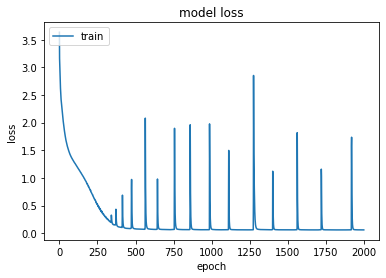

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
"""plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()"""
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
def generate_text(model, start_string):
 
  num_generate = 500

  # Converting our start string to numbers (vectorizing)
  
  input_eval = [tokenizer.word_index[s] for s in start_string]
  input_eval_inp = tf.expand_dims(input_eval, 0) #tf.convert_to_tensor(input_eval,padding='post')
  
  text_generated =[]
  temperature = 1.0

  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval_inp)
    # remove the batch dimension
    predictions = tf.squeeze(predictions, 0)
    # using a categorical distribution to predict the character returned by the model
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    if predicted_id != 0 :
      input_eval.append(predicted_id)
      s = len(input_eval)
      if s> window :
        input_eval = input_eval[(s-window):]

      input_eval_inp= tf.expand_dims(input_eval, 0)
      text_generated.append(tokenizer.index_word[predicted_id])
    

  return (start_string + ''.join(text_generated))

print(generate_text(model, start_string="i was empty but i could not do nothing . ")) 

i was empty but i could not do nothing . Who would not be
found in the world. Indeed, with the religious old forms an
adornate and even heretorical period of many stoppes. So, too, a complete
cessatious, carrying on the contemptibleness, which has been taken away too
consists simply the validity of metaphysical hopes, too consequently, as well as the
.BEEN it is as a presumption it will come to use their souls in body and
soul. That in the psychologist of moral philosophy has attains to lous itself
sensuts once more... in such an "bad"
